df_bo columns: ['seed', 'temperature_kelvin', 'pressure_bar', 'label', 'n_candidates', 'init_strategy', 'n_initial', 'initial_structures', 'max_iter', 'patience', 'global_best', 'acq', 'run_id', 'method', 'acq_param_last', 'iters_done', 'stopped_early', 'final_best', 'ratio_to_optimum', 'found_global_best', 'state']
methods in df_bo: method
bo        60
random    60
Name: count, dtype: int64
states in df_bo: ['T=298K,p=0.1bar', 'T=298K,p=100bar', 'T=298K,p=1bar']
ratio_to_optimum NaNs: 0
global_best NaNs: 0


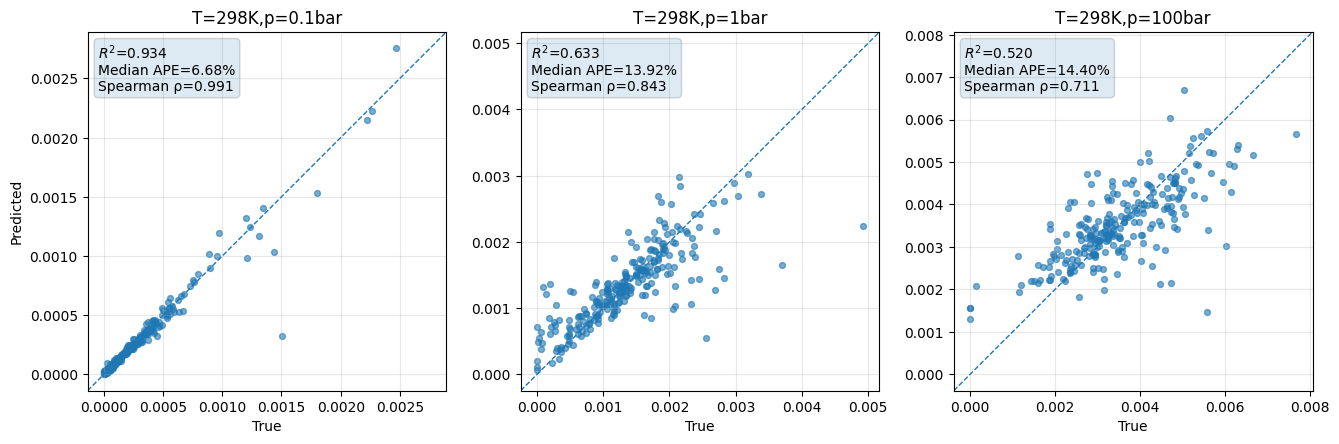

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ----------------------------
# CONFIG
# ----------------------------
BASE = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv")

TEMP = 298
PRESSURES = [0.1, 1.0, 100.0]
LABEL = "beladung_pro_vol"

POOLED_LOG = BASE / "gp_pooled_r2_log_nodens_ucb.csv"
BO_RESULTS = BASE / "bo_random_results_nodens_ucb.csv"
BO_HISTORY = BASE / "bo_random_history_nodens_ucb.csv"

# ----------------------------
# Helpers
# ----------------------------
def state_label(t, p):
    # exakt wie deine frühere states-Liste: ohne Leerzeichen, p mit :g
    return f"T={float(t):.0f}K,p={float(p):g}bar"

def load_oof(t, p):
    f = BASE / f"oof_T{t}_p{p:g}.csv"
    df = pd.read_csv(f)
    df["temperature_kelvin"] = float(t)
    df["pressure_bar"] = float(p)
    df["state"] = state_label(t, p)
    return df

# konsistente state-reihenfolge (nur fürs Plotten)
states = [state_label(TEMP, p) for p in PRESSURES]

def ensure_temp_pressure_and_state(df):
    """
    Erzwingt:
      - temperature_kelvin + pressure_bar numeric
      - state wird IMMER daraus neu gebaut (ignoriert evtl. vorhandene state-Spalte)
    """
    df = df.copy()

    # numeric casts (müssen existieren, sonst knallt es bewusst früh)
    if "temperature_kelvin" not in df.columns or "pressure_bar" not in df.columns:
        raise ValueError("DataFrame needs columns: 'temperature_kelvin' and 'pressure_bar'")

    df["temperature_kelvin"] = pd.to_numeric(df["temperature_kelvin"], errors="coerce")
    df["pressure_bar"] = pd.to_numeric(df["pressure_bar"], errors="coerce")

    # build state from numeric columns (always)
    df["state"] = df.apply(lambda r: state_label(r["temperature_kelvin"], r["pressure_bar"]), axis=1)
    df["state"] = df["state"].astype(str).str.strip()

    return df

def ensure_method(df, default="bo"):
    df = df.copy()
    if "method" not in df.columns:
        df["method"] = default

    df["method"] = df["method"].astype(str).str.strip().str.lower()
    df.loc[df["method"].isin(["bayes", "bayesian", "ucb", "ei"]), "method"] = "bo"
    df.loc[df["method"].isin(["rand", "random", "uniform"]), "method"] = "random"
    return df

# ----------------------------
# Load data
# ----------------------------
df_r2 = pd.read_csv(POOLED_LOG)
df_bo = pd.read_csv(BO_RESULTS)
df_hist = pd.read_csv(BO_HISTORY)

# label filters if present
if "label" in df_r2.columns:
    df_r2 = df_r2[df_r2["label"] == LABEL].copy()
if "label" in df_bo.columns:
    df_bo = df_bo[df_bo["label"] == LABEL].copy()

# normalize: always generate state from numeric columns
df_r2 = ensure_temp_pressure_and_state(df_r2)
df_bo = ensure_method(ensure_temp_pressure_and_state(df_bo), default="bo")
df_hist = ensure_method(ensure_temp_pressure_and_state(df_hist), default="bo")

# --- robust debug prints ---
print("df_bo columns:", df_bo.columns.tolist())
print("methods in df_bo:", df_bo["method"].value_counts(dropna=False))
print("states in df_bo:", sorted(df_bo["state"].unique().tolist()))
if "ratio_to_optimum" in df_bo.columns:
    print("ratio_to_optimum NaNs:", df_bo["ratio_to_optimum"].isna().sum())
if "global_best" in df_bo.columns:
    print("global_best NaNs:", df_bo["global_best"].isna().sum())

# fix columns in history
if "iter" not in df_hist.columns:
    for cand in ["iteration", "step"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "iter"})
            break
if "best_so_far" not in df_hist.columns:
    for cand in ["best", "best_value", "best_sofar"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "best_so_far"})
            break

df_hist["iter"] = pd.to_numeric(df_hist["iter"], errors="coerce")
df_hist["best_so_far"] = pd.to_numeric(df_hist["best_so_far"], errors="coerce")

# load OOFs
oof_all = pd.concat([load_oof(TEMP, p) for p in PRESSURES], ignore_index=True)

# ensure abs rel deviation exists
if "abs_rel_deviation" not in oof_all.columns:
    oof_all["abs_rel_deviation"] = np.abs((oof_all[LABEL] - oof_all[f"{LABEL}_pred"]) / oof_all[LABEL]) * 100


# ============================================================
# PLOT 1: pooled R² + CI per state
# ============================================================
def plot_pooled_r2_ci(df_r2, outfile=BASE/"01_pooled_r2_ci_nodens_ucb.png"):
    d = df_r2.copy()
    d = ensure_temp_pressure_and_state(d)

    # optional: filter temp
    d = d[d["temperature_kelvin"] == float(TEMP)].copy()

    # sichere Reihenfolge
    d = d.set_index("state").reindex(states).reset_index()

    x = np.arange(len(d))
    y = d["pooled_r2"].to_numpy()
    yerr = np.vstack([y - d["ci95_low"].to_numpy(), d["ci95_high"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Pooled $R^2$")
    plt.xlabel("State")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 2: Parity plots (per state)
# ============================================================
def plot_parity_panels(oof_all, outfile=BASE/"02_parity_panels_nodens_ucb.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(4.5 * len(states), 4.5))
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        y_true = df[LABEL].to_numpy()
        y_pred = df[f"{LABEL}_pred"].to_numpy()

        mn = min(np.nanmin(y_true), np.nanmin(y_pred))
        mx = max(np.nanmax(y_true), np.nanmax(y_pred))
        span = mx - mn
        pad = 0.05 * span if span > 0 else 1e-6
        lo = mn - pad
        hi = mx + pad

        ax.scatter(y_true, y_pred, s=18, alpha=0.6)
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)
        if "abs_rel_deviation" in df.columns:
            mdape = np.nanmedian(df["abs_rel_deviation"].to_numpy())
        else:
            # fallback: compute on the fly
            mdape = np.nanmedian(np.abs((y_true - y_pred) / y_true) * 100)
        rho, _ = spearmanr(y_true, y_pred)

        ax.set_title(st)
        ax.set_xlabel("True")
        ax.grid(alpha=0.3)

        ax.text(
            0.03, 0.97,
            f"$R^2$={r2:.3f}\nMedian APE={mdape:.2f}%\nSpearman ρ={rho:.3f}",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round", alpha=0.15)
        )

    axs[0].set_ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 3A: ARD scatter log-y
# ============================================================
def plot_ard_scatter_logy(oof_all, outfile=BASE/"03a_ard_scatter_logy_nodens_ucb.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(14, 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        ax.scatter(df[LABEL], df["abs_rel_deviation"], s=18, alpha=0.6)
        ax.set_title(st)
        ax.set_xlabel("True loading")
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    axs[0].set_ylabel("Absolute Relative Deviation [%]")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 3B: Median + IQR ARD per state
# ============================================================
def plot_ard_median_iqr(oof_all, outfile=BASE/"03b_ard_median_iqr_nodens_ucb.png"):
    rows = []
    for st in states:
        df = oof_all[oof_all["state"] == st]
        if df.empty:
            rows.append((st, np.nan, np.nan, np.nan))
            continue
        med = df["abs_rel_deviation"].median()
        q25 = df["abs_rel_deviation"].quantile(0.25)
        q75 = df["abs_rel_deviation"].quantile(0.75)
        rows.append((st, med, q25, q75))

    d = pd.DataFrame(rows, columns=["state", "median", "q25", "q75"])
    x = np.arange(len(d))

    y = d["median"].to_numpy()
    yerr = np.vstack([y - d["q25"].to_numpy(), d["q75"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Median Absolute Relative Deviation [%]")
    plt.xlabel("State")
    plt.ylim(0, 100)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 4: Best-so-far vs Iteration (BO vs Random)
# ============================================================
def plot_best_so_far_curves(df_hist, states, outfile=BASE/"04_bo_vs_random_best_so_far_nodens_ucb.png"):
    dh = df_hist.copy()

    # require numeric columns; state will be synthesized
    required = {"run_id", "iter", "best_so_far", "method", "temperature_kelvin", "pressure_bar"}
    missing = required.difference(dh.columns)
    if missing:
        raise ValueError(f"df_hist missing columns: {missing}")

    dh = ensure_method(ensure_temp_pressure_and_state(dh), default="bo")
    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    if dh.empty:
        print("No history rows found for the selected states.")
        print("Available states:", sorted(df_hist["state"].astype(str).str.strip().unique().tolist()) if "state" in df_hist.columns else "(state synthesized later)")
        print("Requested states:", states)
        return

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["state"] == st].copy()

        for method in ["bo", "random"]:
            m = sub[sub["method"] == method].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            label = "BO" if method == "bo" else "Random"
            ax.plot(np.arange(max_iter + 1), median, label=label)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 5: CDF of ratio_to_optimum (BO vs Random) per state
# ============================================================
def plot_ratio_cdf(df_bo, states, outfile=BASE/"05_ratio_cdf_nodens_ucb.png"):
    db = df_bo.copy()

    required = {"method", "ratio_to_optimum", "temperature_kelvin", "pressure_bar"}
    missing = required.difference(db.columns)
    if missing:
        raise ValueError(f"df_bo missing columns: {missing}")

    db = ensure_method(ensure_temp_pressure_and_state(db), default="bo")
    db = db[db["state"].isin(states)].copy()
    if db.empty:
        print("No BO/Random result rows found for selected states.")
        print("Available states:", sorted(db["state"].unique().tolist()))
        print("Requested states:", states)
        return

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = db[db["state"] == st].copy()

        for method in ["bo", "random"]:
            vals = sub[sub["method"] == method]["ratio_to_optimum"].dropna().to_numpy()
            if len(vals) == 0:
                continue
            vals = np.sort(vals)
            y = np.arange(1, len(vals) + 1) / len(vals)
            label = "BO" if method == "bo" else "Random"
            ax.plot(vals, y, label=label)

        ax.set_title(st)
        ax.set_xlabel("Prediction Best / Global Best")
        ax.set_xlim(0, 1.02)
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Cumulative Distribution Function")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 6: Time-to-threshold
# ============================================================
def plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99),
                           outfile=BASE/"06_time_to_threshold_nodens_ucb.png"):
    dh = ensure_method(ensure_temp_pressure_and_state(df_hist), default="bo")
    db = ensure_method(ensure_temp_pressure_and_state(df_bo), default="bo")

    req_h = {"run_id", "iter", "best_so_far", "state", "method"}
    req_b = {"state", "method", "global_best"}
    if req_h.difference(dh.columns):
        raise ValueError(f"df_hist missing columns: {req_h.difference(dh.columns)}")
    if req_b.difference(db.columns):
        raise ValueError(f"df_bo missing columns: {req_b.difference(db.columns)}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].copy()

    if dh.empty or db.empty:
        print("No data for time-to-threshold after filtering.")
        return

    gb = db.groupby("state")["global_best"].mean().to_dict()

    rows = []
    for st in states:
        if st not in gb or gb[st] == 0 or np.isnan(gb[st]):
            continue
        gbest = gb[st]

        sub = dh[dh["state"] == st].copy()

        for method in ["bo", "random"]:
            m = sub[sub["method"] == method].copy()
            if m.empty:
                continue

            for run_id, grp in m.groupby("run_id"):
                grp = grp.sort_values("iter")
                for thr in thresholds:
                    target = thr * gbest
                    hit = grp[grp["best_so_far"] >= target]
                    it = float(hit["iter"].iloc[0]) if len(hit) else np.nan
                    rows.append({"state": st, "method": method, "threshold": thr, "iters_to_thr": it})

    d = pd.DataFrame(rows).dropna(subset=["iters_to_thr"])
    if d.empty:
        print("No threshold hits found.")
        return

    fig, axs = plt.subplots(1, len(thresholds), figsize=(5.2 * len(thresholds), 4.5), sharey=True)
    if len(thresholds) == 1:
        axs = [axs]

    for ax, thr in zip(axs, thresholds):
        sub = d[d["threshold"] == thr]

        x = np.arange(len(states))
        w = 0.35
        bo_data = [sub[(sub["state"] == st) & (sub["method"] == "bo")]["iters_to_thr"].to_numpy() for st in states]
        rd_data = [sub[(sub["state"] == st) & (sub["method"] == "random")]["iters_to_thr"].to_numpy() for st in states]

        ax.boxplot(bo_data, positions=x - w/2, widths=0.25, showfliers=False)
        ax.boxplot(rd_data, positions=x + w/2, widths=0.25, showfliers=False)

        ax.set_xticks(x)
        ax.set_xticklabels(states, rotation=35, ha="right")
        ax.set_title(f"{int(thr*100)}% of optimum")
        ax.grid(alpha=0.3)

        ax.plot([], [], label="BO")
        ax.plot([], [], label="Random")
        ax.legend(frameon=False, loc="upper right")

    axs[0].set_ylabel("Iterations to reach threshold")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

def plot_best_so_far_curves1(df_hist, df_bo, states,
                            outfile=BASE/"04_bo_vs_random_best_so_far_nodens_ucb.png"):
    dh = df_hist.copy()
    db = df_bo.copy()

    # --- requirements ---
    req_h = {"run_id", "iter", "best_so_far", "method", "temperature_kelvin", "pressure_bar"}
    miss_h = req_h.difference(dh.columns)
    if miss_h:
        raise ValueError(f"df_hist missing columns: {miss_h}")

    req_b = {"global_best", "temperature_kelvin", "pressure_bar"}
    miss_b = req_b.difference(db.columns)
    if miss_b:
        raise ValueError(f"df_bo missing columns: {miss_b}")

    # --- normalize ---
    dh = ensure_method(ensure_temp_pressure_and_state(dh), default="bo")
    db = ensure_method(ensure_temp_pressure_and_state(db), default="bo")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty:
        print("No history rows found for the selected states.")
        return

    # global_best pro state (typisch konstant, aber wir nehmen robust den Median)
    gb = db.groupby("state")["global_best"].median().to_dict()

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["state"] == st].copy()

        # --- horizontal global optimum line ---
        if st in gb and np.isfinite(gb[st]):
            ax.axhline(gb[st], linestyle="--", linewidth=1.2, alpha=0.9, label="Global optimum")

        for method in ["bo", "random"]:
            m = sub[sub["method"] == method].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            label = "BO" if method == "bo" else "Random"
            ax.plot(np.arange(max_iter + 1), median, label=label)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)

        # Legende: doppelte Labels vermeiden
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()



# ============================================================
# RUN PLOTS
# ============================================================
#plot_pooled_r2_ci(df_r2)
plot_parity_panels(oof_all)
#plot_ard_scatter_logy(oof_all)
#plot_ard_median_iqr(oof_all)
#plot_best_so_far_curves1(df_hist, df_bo, states)
#plot_ratio_cdf(df_bo, states)
#plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99))

df_bo columns: ['seed', 'temp_high', 'pres_high', 'temp_low', 'pres_low', 'wc_state', 'label', 'n_candidates', 'init_strategy', 'n_initial', 'initial_structures', 'max_iter', 'patience', 'global_best', 'acq', 'run_id', 'method', 'acq_param_last', 'iters_done', 'stopped_early', 'final_best', 'ratio_to_optimum', 'found_global_best']
methods in df_bo: method
bo        60
random    60
Name: count, dtype: int64
wc_states in df_bo: ['(T=298K,p=1)-(T=298K,p=0.1)', '(T=298K,p=5)-(T=298K,p=1)', '(T=400K,p=1)-(T=298K,p=1)']
ratio_to_optimum NaNs: 0
global_best NaNs: 0


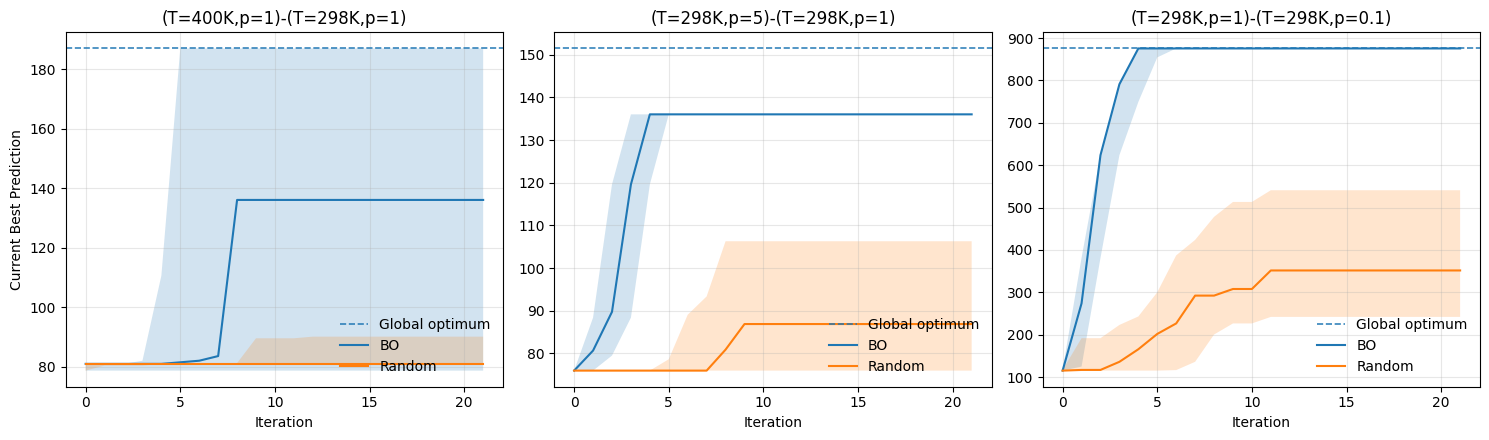

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ----------------------------
# CONFIG
# ----------------------------
BASE = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv")

LABEL = "working_capacity"

POOLED_LOG = BASE / "gp_pooled_r2_log_wc_dens_ucb5.csv"
BO_RESULTS = BASE / "bo_random_results_wc_dens_ucb5.csv"
BO_HISTORY = BASE / "bo_random_history_wc_dens_ucb5.csv"

# WC states must match what you used in training
# (temp_high, pres_high, temp_low, pres_low)
WC_STATES = [ 
    (400.0, 1.0,   298.0, 1.0),
    (298.0, 5.0, 298.0, 1.0),
    #(298.0, 1.0,   298.0, 0.1),
    (298.0, 1.0,   298.0, 0.1),
    #(373.0, 1.0,   298.0, 1.0),
    #(348.0, 1.0,   298.0, 1.0)
]

# ----------------------------
# Helpers
# ----------------------------
def wc_state_label(tH, pH, tL, pL):
    return f"(T={float(tH):.0f}K,p={float(pH):g})-(T={float(tL):.0f}K,p={float(pL):g})"

def load_oof_wc(tH, pH, tL, pL):
    f = BASE / f"oof_wc_TH{tH:g}_pH{pH:g}_TL{tL:g}_pL{pL:g}.csv"
    df = pd.read_csv(f)

    # guarantee numeric + label column
    df["temp_high"] = float(tH)
    df["pres_high"] = float(pH)
    df["temp_low"]  = float(tL)
    df["pres_low"]  = float(pL)
    df["wc_state"]  = wc_state_label(tH, pH, tL, pL)
    return df

def ensure_wc_state(df):
    """
    Ensure:
      - temp_high/pres_high/temp_low/pres_low numeric (if present)
      - wc_state exists (from the 4 numbers)
    """
    df = df.copy()

    for c in ["temp_high", "pres_high", "temp_low", "pres_low"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "wc_state" not in df.columns and {"temp_high","pres_high","temp_low","pres_low"}.issubset(df.columns):
        df["wc_state"] = df.apply(lambda r: wc_state_label(r["temp_high"], r["pres_high"], r["temp_low"], r["pres_low"]), axis=1)

    if "wc_state" in df.columns:
        df["wc_state"] = df["wc_state"].astype(str).str.strip()

    return df

def ensure_method(df, default="bo"):
    df = df.copy()
    if "method" not in df.columns:
        df["method"] = default

    df["method"] = df["method"].astype(str).str.strip().str.lower()
    df.loc[df["method"].isin(["bayes", "bayesian", "ucb", "ei"]), "method"] = "bo"
    df.loc[df["method"].isin(["rand", "random", "uniform"]), "method"] = "random"
    return df

# consistent state order for plotting
states = [wc_state_label(*tpl) for tpl in WC_STATES]

# ----------------------------
# Load data
# ----------------------------
df_r2   = pd.read_csv(POOLED_LOG)
df_bo   = pd.read_csv(BO_RESULTS)
df_hist = pd.read_csv(BO_HISTORY)

# label filters if present
if "label" in df_r2.columns:
    df_r2 = df_r2[df_r2["label"] == LABEL].copy()
if "label" in df_bo.columns:
    df_bo = df_bo[df_bo["label"] == LABEL].copy()

# normalize
df_r2   = ensure_wc_state(df_r2)
df_bo   = ensure_method(ensure_wc_state(df_bo), default="bo")
df_hist = ensure_method(ensure_wc_state(df_hist), default="bo")

# debug prints
print("df_bo columns:", df_bo.columns.tolist())
print("methods in df_bo:", df_bo["method"].value_counts(dropna=False))
print("wc_states in df_bo:", sorted(df_bo["wc_state"].unique().tolist()) if "wc_state" in df_bo.columns else "(no wc_state column)")
if "ratio_to_optimum" in df_bo.columns:
    print("ratio_to_optimum NaNs:", df_bo["ratio_to_optimum"].isna().sum())
if "global_best" in df_bo.columns:
    print("global_best NaNs:", df_bo["global_best"].isna().sum())

# fix columns in history
if "iter" not in df_hist.columns:
    for cand in ["iteration", "step"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "iter"})
            break
if "best_so_far" not in df_hist.columns:
    for cand in ["best", "best_value", "best_sofar"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "best_so_far"})
            break

df_hist["iter"] = pd.to_numeric(df_hist["iter"], errors="coerce")
df_hist["best_so_far"] = pd.to_numeric(df_hist["best_so_far"], errors="coerce")

# load OOFs for all WC states
oof_all = pd.concat([load_oof_wc(*tpl) for tpl in WC_STATES], ignore_index=True)

# ensure abs rel deviation exists
if "abs_rel_deviation" not in oof_all.columns:
    oof_all["abs_rel_deviation"] = np.abs(
        (oof_all[LABEL] - oof_all[f"{LABEL}_pred"]) / oof_all[LABEL]
    ) * 100


# ============================================================
# PLOT 1: pooled R² + CI per WC state
# ============================================================
def plot_pooled_r2_ci_wc(df_r2, outfile=BASE/"01_pooled_r2_ci_wc_ucb.png"):
    d = ensure_wc_state(df_r2)

    # prefer explicit 'wc_state' column (your training logger writes it)
    if "wc_state" not in d.columns:
        d["wc_state"] = d.apply(lambda r: wc_state_label(r["temp_high"], r["pres_high"], r["temp_low"], r["pres_low"]), axis=1)

    d = d.set_index("wc_state").reindex(states).reset_index()

    x = np.arange(len(d))
    y = d["pooled_r2"].to_numpy()
    yerr = np.vstack([y - d["ci95_low"].to_numpy(), d["ci95_high"].to_numpy() - y])

    plt.figure(figsize=(10, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["wc_state"], rotation=20, ha="right")
    plt.ylabel("Pooled $R^2$")
    plt.xlabel("State")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 2: Parity plots (per WC state)
# ============================================================
def plot_parity_panels_wc(oof_all, outfile=BASE/"02_parity_panels_wc_ucb.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5))
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["wc_state"] == st].copy()

        y_true = df[LABEL].to_numpy()
        y_pred = df[f"{LABEL}_pred"].to_numpy()

        mn = min(np.nanmin(y_true), np.nanmin(y_pred))
        mx = max(np.nanmax(y_true), np.nanmax(y_pred))

        span = mx - mn
        pad = 0.05 * span if span > 0 else 1e-6
        lo = mn - pad
        hi = mx + pad

        ax.scatter(y_true, y_pred, s=18, alpha=0.6)
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        # metrics
        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)
        mdape = np.nanmedian(df["abs_rel_deviation"].to_numpy())
        rho, _ = spearmanr(y_true, y_pred)

        ax.set_title(st)
        ax.set_xlabel("True Working Capacity")
        ax.grid(alpha=0.3)

        ax.text(
            0.03, 0.97,
            f"$R^2$={r2:.3f}\nMedian APE={mdape:.2f}%\nSpearman ρ={rho:.3f}",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round", alpha=0.15)
        )

    axs[0].set_ylabel("Predicted Working Capacity")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 3A: ARD scatter log-y (per WC state)
# ============================================================
def plot_ard_scatter_logy_wc(oof_all, outfile=BASE/"03a_ard_scatter_logy_wc_ucb.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["wc_state"] == st].copy()
        ax.scatter(df[LABEL], df["abs_rel_deviation"], s=18, alpha=0.6)
        ax.set_title(st)
        ax.set_xlabel("True Working Capacity")
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    axs[0].set_ylabel("Absolute relative deviation [%]")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 3B: Median + IQR ARD per WC state
# ============================================================
def plot_ard_median_iqr_wc(oof_all, outfile=BASE/"03b_ard_median_iqr_wc_ucb.png"):
    rows = []
    for st in states:
        df = oof_all[oof_all["wc_state"] == st]
        med = df["abs_rel_deviation"].median()
        q25 = df["abs_rel_deviation"].quantile(0.25)
        q75 = df["abs_rel_deviation"].quantile(0.75)
        rows.append((st, med, q25, q75))

    d = pd.DataFrame(rows, columns=["wc_state", "median", "q25", "q75"])
    x = np.arange(len(d))

    y = d["median"].to_numpy()
    yerr = np.vstack([y - d["q25"].to_numpy(), d["q75"].to_numpy() - y])

    plt.figure(figsize=(10, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["wc_state"], rotation=20, ha="right")
    plt.ylabel("Median Absolute Relative Deviation [%]")
    plt.xlabel("State")
    plt.ylim(0, 100)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 4: Best-so-far vs Iteration (BO vs Random) per WC state
# ============================================================
def plot_best_so_far_curves_wc(df_hist, states, outfile=BASE/"04_bo_vs_random_best_so_far_wc_ucb.png"):
    dh = df_hist.copy()

    required = {"run_id", "iter", "best_so_far", "method", "wc_state"}
    missing = required.difference(dh.columns)
    if missing:
        raise ValueError(f"df_hist missing columns: {missing}")

    dh = ensure_method(ensure_wc_state(dh), default="bo")
    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")

    dh = dh[dh["wc_state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    if dh.empty:
        print("No history rows found for selected WC states.")
        print("Available wc_states:", sorted(df_hist["wc_state"].astype(str).str.strip().unique().tolist()) if "wc_state" in df_hist.columns else "(no wc_state)")
        print("Requested wc_states:", states)
        return

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["wc_state"] == st].copy()

        for method in ["bo", "random"]:
            m = sub[sub["method"] == method].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            label = "BO" if method == "bo" else "Random"
            ax.plot(np.arange(max_iter + 1), median, label=label)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 5: CDF of ratio_to_optimum (BO vs Random) per WC state
# ============================================================
def plot_ratio_cdf_wc(df_bo, states, outfile=BASE/"05_ratio_cdf_wc_ucb.png"):
    db = df_bo.copy()

    required = {"method", "ratio_to_optimum", "wc_state"}
    missing = required.difference(db.columns)
    if missing:
        raise ValueError(f"df_bo missing columns: {missing}")

    db = ensure_method(ensure_wc_state(db), default="bo")
    db = db[db["wc_state"].isin(states)].copy()

    if db.empty:
        print("No BO/Random result rows found for selected WC states.")
        print("Available wc_states:", sorted(df_bo["wc_state"].astype(str).str.strip().unique().tolist()) if "wc_state" in df_bo.columns else "(no wc_state)")
        print("Requested wc_states:", states)
        return

    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = db[db["wc_state"] == st].copy()

        for method in ["bo", "random"]:
            vals = sub[sub["method"] == method]["ratio_to_optimum"].dropna().to_numpy()
            if len(vals) == 0:
                continue
            vals = np.sort(vals)
            y = np.arange(1, len(vals) + 1) / len(vals)
            label = "BO" if method == "bo" else "Random"
            ax.plot(vals, y, label=label)

        ax.set_title(st)
        ax.set_xlabel("Prediction Best / Global Best")
        ax.set_xlim(0, 1.02)
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Cumulative Distribution Function")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# PLOT 6: Time-to-threshold per WC state
# ============================================================
def plot_time_to_threshold_wc(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99),
                              outfile=BASE/"06_time_to_threshold_wc_ucb.png"):
    dh = ensure_method(ensure_wc_state(df_hist), default="bo")
    db = ensure_method(ensure_wc_state(df_bo), default="bo")

    req_h = {"run_id", "iter", "best_so_far", "wc_state", "method"}
    req_b = {"wc_state", "method", "global_best"}
    if req_h.difference(dh.columns):
        raise ValueError(f"df_hist missing columns: {req_h.difference(dh.columns)}")
    if req_b.difference(db.columns):
        raise ValueError(f"df_bo missing columns: {req_b.difference(db.columns)}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")

    dh = dh[dh["wc_state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["wc_state"].isin(states)].copy()

    if dh.empty or db.empty:
        print("No data for time-to-threshold after filtering.")
        return

    gb = db.groupby("wc_state")["global_best"].mean().to_dict()

    rows = []
    for st in states:
        if st not in gb or gb[st] == 0 or np.isnan(gb[st]):
            continue
        gbest = gb[st]

        sub = dh[dh["wc_state"] == st].copy()
        for method in ["bo", "random"]:
            m = sub[sub["method"] == method].copy()
            if m.empty:
                continue

            for run_id, grp in m.groupby("run_id"):
                grp = grp.sort_values("iter")
                for thr in thresholds:
                    target = thr * gbest
                    hit = grp[grp["best_so_far"] >= target]
                    it = float(hit["iter"].iloc[0]) if len(hit) else np.nan
                    rows.append({"wc_state": st, "method": method, "threshold": thr, "iters_to_thr": it})

    d = pd.DataFrame(rows).dropna(subset=["iters_to_thr"])
    if d.empty:
        print("No threshold hits found.")
        return

    fig, axs = plt.subplots(1, len(thresholds), figsize=(5.2 * len(thresholds), 4.5), sharey=True)
    if len(thresholds) == 1:
        axs = [axs]

    for ax, thr in zip(axs, thresholds):
        sub = d[d["threshold"] == thr]

        x = np.arange(len(states))
        w = 0.35
        bo_data = [sub[(sub["wc_state"] == st) & (sub["method"] == "bo")]["iters_to_thr"].to_numpy() for st in states]
        rd_data = [sub[(sub["wc_state"] == st) & (sub["method"] == "random")]["iters_to_thr"].to_numpy() for st in states]

        ax.boxplot(bo_data, positions=x - w/2, widths=0.25, showfliers=False)
        ax.boxplot(rd_data, positions=x + w/2, widths=0.25, showfliers=False)

        ax.set_xticks(x)
        ax.set_xticklabels(states, rotation=20, ha="right")
        ax.set_title(f"{int(thr*100)}% of optimum")
        ax.grid(alpha=0.3)

        ax.plot([], [], label="BO")
        ax.plot([], [], label="Random")
        ax.legend(frameon=False, loc="upper right")

    axs[0].set_ylabel("Iterations to reach threshold")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

def plot_best_so_far_curves_wc111(df_hist, df_bo, states,
                               outfile=BASE/"04_bo_vs_random_best_so_far_wc_ucb.png"):
    dh = df_hist.copy()
    db = df_bo.copy()

    # --- requirements ---
    req_h = {"run_id", "iter", "best_so_far", "method", "wc_state"}
    miss_h = req_h.difference(dh.columns)
    if miss_h:
        raise ValueError(f"df_hist missing columns: {miss_h}")

    req_b = {"global_best", "wc_state"}
    miss_b = req_b.difference(db.columns)
    if miss_b:
        raise ValueError(f"df_bo missing columns: {miss_b}")

    # --- normalize ---
    dh = ensure_method(ensure_wc_state(dh), default="bo")
    db = ensure_method(ensure_wc_state(db), default="bo")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["wc_state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["wc_state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty:
        print("No history rows found for selected WC states.")
        print("Requested wc_states:", states)
        return

    # global_best pro wc_state (robust: median)
    gb = db.groupby("wc_state")["global_best"].median().to_dict()

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["wc_state"] == st].copy()

        # --- horizontal global optimum line ---
        if st in gb and np.isfinite(gb[st]):
            ax.axhline(gb[st], linestyle="--", linewidth=1.2, alpha=0.9, label="Global optimum")

        for method in ["bo", "random"]:
            m = sub[sub["method"] == method].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            label = "BO" if method == "bo" else "Random"
            ax.plot(np.arange(max_iter + 1), median, label=label)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)

        # Legend ohne doppelte Einträge
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# RUN PLOTS
# ============================================================
#plot_pooled_r2_ci_wc(df_r2)
#plot_parity_panels_wc(oof_all)
#plot_ard_scatter_logy_wc(oof_all)
#plot_ard_median_iqr_wc(oof_all)
plot_best_so_far_curves_wc111(df_hist, df_bo, states)
#plot_ratio_cdf_wc(df_bo, states)
#plot_time_to_threshold_wc(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99))
